# Инициализация для BigCLAM

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat
import subprocess
import os
from big_clam import BigClam, GetNeighborhoodConductance, conductanceLocalMin
from big_clam_gamma import BigClamGamma

%matplotlib inline 

In [2]:
# для отрисовки графов
from plotly import tools
import plotly.plotly as py
from plotly.graph_objs import *

In [3]:
from Experiments import *

Текущая инициализация выбирается с помощью метода, который называется locally minimal neighborhoods. Выбирается локальный минимум функционала под названием Conductance (проводимость) по всем эгографам. 

Conductance обозначается как $\phi$ и вычисляется для подграфа $S \in G$ как 

$$
\phi(S) = \dfrac{\mathrm{cut}(S)}{\min(\mathrm{vol}(S), \mathrm{vol}( \bar S))}
$$

миниум берется, т.к. Величина рассматривается для "меньшей" выделенной части графа. Здесь

$$\mathrm{cut}(S) = \mathrm{cut}(S, \bar S)=\sum_{\substack{(v,u)\in E\\ v \in S\\ u \in \bar S}} a_{vu},$$

$$\mathrm{vol}(S) =\sum_{(v,u)\in S} a_{vu}.$$

Возьмем стандартный пример для экспериментов и посмотрим, как на нем ведет себя эта величина

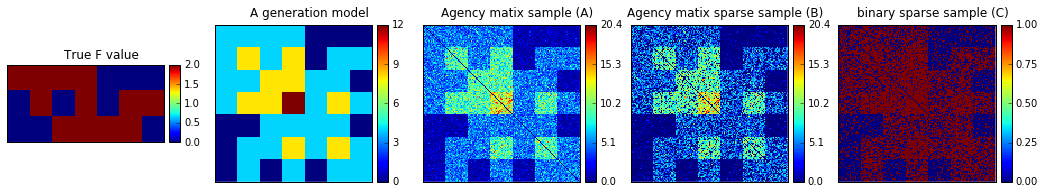

In [4]:
F_true = Fs3[0]
A = gamma_model_test_data(F_true)
power = 0.2
P = 1 - np.exp(- power * A)
mask = P <= np.random.rand(*A.shape)

B = A.copy()
B[mask] = 0
C = B.copy()
C[B != 0] = 1

draw_test_sample(F_true, A, B, C)

[12, 9, 84, 138, 122, 97, 91, 121]


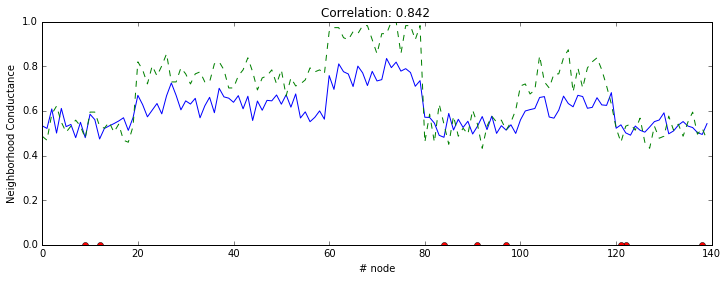

In [5]:
plt.figure(figsize=(12,4))
cond = GetNeighborhoodConductance(C)
degreeNorm = np.sum(C, axis=0) / np.max(np.sum(C, axis=0))
localmax = conductanceLocalMin(C)
print localmax
plt.plot(cond, 'b')
plt.plot(degreeNorm, 'g--')
plt.plot(localmax, [0]*len(localmax), 'r-o')
plt.xlabel('# node')
plt.ylabel('Neighborhood Conductance')
plt.title('Correlation: {:.3f} '.format(np.corrcoef(cond, degreeNorm)[1][0]))

Видно, что Conductance (синий график) очень хорошо улавливает струкруту матрицы, из которой генерируется граф (зеленый график показывает отнормированную сумму весов каждой из вершин матрицы А).

Посмотрим на эту величину на графе

In [6]:
def draw_graph(C, pos=None, color=None, highlight=None):

    G = nx.Graph(C)
    if pos is None:
        pos=nx.layout.spectral_layout(G)
        center = sum(pos[key] for key in pos) / len(pos)
        pos = {key:np.sign(pos[key]-center)*(2*(np.abs(pos[key]-center)))**0.6+center for key in pos}

    if color is None:
        color = GetNeighborhoodConductance(C)

    nx.set_node_attributes(G, 'pos', pos)
    nx.set_node_attributes(G, 'cond', color)

    edge_trace = Scatter(
        x=[], y=[],
        line=Line(width=0.15,color='rgba(100, 100, 100, 0.5)'),
        hoverinfo='none', mode='lines')

    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += [x0, x1, None]
        edge_trace['y'] += [y0, y1, None]

    node_trace = Scatter(
        x=[], y=[], text=[],
        mode='markers',
        hoverinfo='text',
        marker=Marker(
            showscale=True,
            colorscale='YIGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Neighborhood Conductance',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2, color=[])))

    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['marker']['line']['color'].append( '#911' if node in highlight else '#444')
        node_trace['marker']['color'].append(cond[node])
        node_info = '{}: {:.3f}'.format(node, cond[node]) + (' {}'.format(highlight.index(node)) if node in highlight else '' )
        node_trace['text'].append(node_info)

    fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='Sample Network graph',
                titlefont=dict(size=16),
                showlegend=False,
                width=800,
                height=650,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
    
    return fig

In [7]:
fig = draw_graph(C, highlight=localmax)
py.iplot(fig, filename='networkx')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zurk/0 or inside your plot.ly account where it is named 'networkx'


Посмотрим на количество общих вершин в эгографах вершин, где достигается локальный минимум проводимости.

**BTW**: позиции вершин расчитаны с помощью спектрального метода и он очень здорово располагает и отрисовывает такой модельный пример

In [8]:
Z = C[localmax].dot(C[localmax].T)/np.sum(C[localmax], axis=1)
np.fill_diagonal(Z, 0)
                    
data = [Heatmap(z=Z)]
fig = Figure(data=data, layout=Layout( width=400, height=400,  title=' Nodes interseption fraction'))
py.iplot(fig, filename='Egograph interception')

Видим местами значительные пересечения. Например, берем первый и второй по проводимости эгограф, получаем долю пересеечния в 60%. Это очень много. По первому графику видно, что локальные минимумы есть в каждой из стуктурных частей графа. Попробуем использовать эту матрицу, как матрицу штрафов для выбора сообществ

In [9]:
def getSeedCenters(C, K=None, w = 1):
    if K is None:
        K = len(C)
    cond = GetNeighborhoodConductance(C)
    degreeNorm = np.sum(C, axis=0) / np.max(np.sum(C, axis=0))
    localmax = conductanceLocalMin(C)
    
    res = []
    res.append(localmax[0])
    localmax.pop(0)
    i = len(res)
    
    while i <= K and i <= len(localmax):
        all_nodes = np.any(C[res] != 0, axis=0)
        temp = C[localmax].dot(all_nodes.T)
        interseption = temp / np.sum(C[localmax], axis=1)
        order = cond[localmax] - w * interseption
        k = np.argmax(order)
        res.append(localmax[k])
        localmax.pop(k)
    return res

In [10]:
A, B = getSeedCenters(C), conductanceLocalMin(C)
print A, B

[12, 121, 97, 91, 122, 9, 138, 84] [12, 9, 84, 138, 122, 97, 91, 121]


In [11]:
fig = draw_graph(C, highlight=A[:3])
fig['layout'].update(title='3 first Smart Seed Centers')
py.iplot(fig, filename='Network')

Итак, результат достигнут. Начальные точки лежат в разрозненных частях графа. До этого две точки: 12 и 9 лежали в одной части. Такой подход явно поможет избежать подобных ситуаций.

# Тест на реальных данных